In [37]:
%matplotlib inline


In [38]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torch
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

import torch.nn as nn

from tqdm import tqdm_notebook

from torchvision import transforms
from torchvision import datasets
from os.path import join

from deepsith import DeepSITH

from tqdm.notebook import tqdm

import random

from csv import DictWriter
# if gpu is to be used
use_cuda = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor

ttype =FloatTensor

import seaborn as sn
print(use_cuda)
import pickle

sn.set_context("poster")

True


In [39]:
class DeepSITH_Classifier(nn.Module):
    def __init__(self, out_features, layer_params, dropout=.1):
        super(DeepSITH_Classifier, self).__init__()
        last_hidden = layer_params[-1]['hidden_size']
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout)
        self.to_out = nn.Linear(last_hidden, out_features)
    def forward(self, inp):
        x = self.hs(inp)
        x = self.to_out(x)
        return x

# Load Stimuli

In [40]:
# Same seed and supposed Permutation as the coRNN paper
torch.manual_seed(12008)
permute = torch.randperm(784)

In [41]:
print(permute)

tensor([ 91,  97, 471, 426, 157, 451, 312, 198, 117, 454, 357, 608, 711, 417,
         22, 498, 207, 252,  18, 541, 697, 437, 777, 208, 294, 173, 449, 141,
        515, 524, 648, 490, 724,  56, 635, 531, 696,   7, 116, 547,  31, 263,
        421,  54, 647, 314, 380, 187, 520, 733,  93, 201, 528, 147, 710, 352,
        681, 175, 580, 229, 383,  40, 403, 253, 572, 172,  30, 672, 286, 545,
         16, 379, 196, 737, 592, 759, 607, 124,  24, 485, 632,  98, 119, 533,
        698, 258, 716,  68, 742, 156, 539, 521, 234, 653, 587, 553, 422, 615,
        365, 668, 491, 448, 188, 743, 164, 750, 158, 675, 612, 367,  55, 105,
        594, 411, 713, 557,  13, 638, 765, 764, 180, 336, 107, 755, 165, 275,
        574, 598, 492, 465, 373, 374, 516, 645, 543, 302, 102, 625, 486, 353,
        658,  45, 651, 622, 661,  63, 100, 634,   1, 566, 407, 559, 425, 311,
        214,  49,  69, 548, 261, 186, 649, 287, 295,  67, 205,  41, 640, 611,
        555,  61, 386, 690, 266, 167,  82, 741, 650, 211, 413, 7

In [42]:
norm = transforms.Normalize((.1307,), (.3081,), )

In [43]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((.1307,), (.3081,))
                               ])
ds1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
ds2 = datasets.MNIST('../data', train=False, download=True, transform=transform)
train_loader=torch.utils.data.DataLoader(ds1,batch_size=batch_size, 
                                         num_workers=1, pin_memory=True, shuffle=True)
test_loader=torch.utils.data.DataLoader(ds2, batch_size=batch_size, 
                                        num_workers=1, pin_memory=True, shuffle=True)

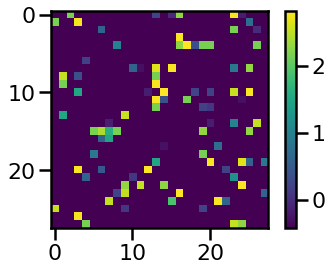

In [44]:
testi = next(iter(test_loader))[0]

plt.imshow(testi[0].reshape(-1)[permute].reshape(28,28))

plt.colorbar()

In [45]:
testi.shape

torch.Size([64, 1, 28, 28])

# Define test and train

In [46]:

def train(model, ttype, train_loader, test_loader, optimizer, loss_func, epoch, 
          permute=None, loss_buffer_size=800, batch_size=4, device='cuda',
          prog_bar=None):
    
    assert(loss_buffer_size%batch_size==0)
    if permute is None:
        permute = torch.LongTensor(list(range(784)))
        
    losses = []
    perfs = []
    last_test_perf = 0
    best_test_perf = -1
    
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data = data.to(device).view(data.shape[0],1,1,-1)
        target = target.to(device)
        optimizer.zero_grad()
        out = model(data[:, :, :, permute])
        loss = loss_func(out[:, -1, :],
                         target)

        loss.backward()
        optimizer.step()

        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      target).sum().item())
        perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        losses = losses[int(-loss_buffer_size/batch_size):]
        if not (prog_bar is None):
            # Update progress_bar
            s = "{}:{} Loss: {:.4f}, perf: {:.4f}, valid: {:.4f}"
            format_list = [e,batch_idx*batch_size, np.mean(losses), 
                           np.sum(perfs)/((len(perfs))*batch_size), last_test_perf]         
            s = s.format(*format_list)
            prog_bar.set_description(s)
        
        if ((batch_idx*batch_size)%loss_buffer_size == 0) & (batch_idx != 0):
            loss_track = {}
            # last_test_perf = test(model, 'cuda', test_loader, 
            #                       batch_size=batch_size, 
            #                       permute=permute)
            loss_track['avg_loss'] = np.mean(losses)
            #loss_track['last_test'] = last_test_perf
            loss_track['epoch'] = epoch
            loss_track['batch_idx'] = batch_idx
            loss_track['train_perf']= np.sum(perfs)/((len(perfs))*batch_size)
            
            #if best_test_perf < last_test_perf:
            #    torch.save(model.state_dict(), perf_file[:-4]+".pt")
            #    best_test_perf = last_test_perf

                
def test(model, device, test_loader, batch_size=4, permute=None):
    if permute is None:
        permute = torch.LongTensor(list(range(784)))
        
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device).view(data.shape[0],1,1,-1)
            target = target.to(device)
            
            out = model(data[:,:,:, permute])
            pred = out[:, -1].argmax(dim=-1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += 1
    return correct / len(test_loader.dataset)

# Setup the model

In [47]:
g = 0.0
sith_params1 = {"in_features":1, 
                "tau_min":1, "tau_max":30.0, "buff_max":50,
                "k":125, 'dt':1,
                "ntau":20, 'g':g,  
                "ttype":ttype, "batch_norm":True,
                "hidden_size":60, "act_func":nn.ReLU()
               }
sith_params2 = {"in_features":sith_params1['hidden_size'], 
                "tau_min":1, "tau_max":150.0, "buff_max":250,
                "k":61, 'dt':1,
                "ntau":20, 'g':g, 
                "ttype":ttype, "batch_norm":True,
                "hidden_size":60, "act_func":nn.ReLU()
                }
sith_params3 = {"in_features":sith_params2['hidden_size'], 
                "tau_min":1, "tau_max":750.0, "buff_max":1500,
                "k":35, 'dt':1,
                "ntau":20, 'g':g, 
                "ttype":ttype, "batch_norm":True,
                "hidden_size":60, "act_func":nn.ReLU()
                }



layer_params = [sith_params1, sith_params2, sith_params3]


model = DeepSITH_Classifier(10,
                           layer_params=layer_params, 
                           dropout=0.2).cuda()

tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 146350
DeepSITH_Classifier(
  (hs): DeepSITH(
    (layers): ModuleList(
      (0): _DeepSITH_core(
        (sith): iSITH(ntau=20, tau_min=1, tau_max=30.0, buff_max=50, dt=1, k=125, g=0.0)
        (linear): Linear(in_features=20, out_features=60, bias=True)
        (act_func): ReLU()
        (dense_bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): _DeepSITH_core(
        (sith): iSITH(ntau=20, tau_min=1, tau_max=150.0, buff_max=250, dt=1, k=61, g=0.0)
        (linear): Linear(in_features=1200, out_features=60, bias=True)
        (act_func): ReLU()
        (dense_bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): _DeepSITH_core(
        (sith): iSITH(ntau=20, tau_min=1, tau_max=750.0, buff_max=1500, dt=1, k=35, g=0.0)
        (linear): Linear(in_features=1200, out_features=60, bias=True)
        (act_func): ReLU()
        (dense_bn): BatchNorm1d(60, eps=1e-05, momentu

In [48]:
epochs = 90
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
sched = StepLR(optimizer, step_size=30, gamma=0.1)
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
test_perf = []
for e in progress_bar:
    train(model, ttype, train_loader, test_loader, optimizer, loss_func, batch_size=batch_size,
          epoch=e, loss_buffer_size=64*32, 
          prog_bar=progress_bar, permute=permute)
    last_test_perf = test(model, 'cuda', test_loader, 
                                  batch_size=batch_size, 
                                  permute=permute)
    test_perf.append({"epoch":e,
                      'test':last_test_perf})
    sched.step()

  0%|     | 0/90 [00:00<?, ?it/s]     

KeyboardInterrupt: 

# Find Errors

In [ ]:
test(model, 'cuda', test_loader, 
     batch_size=batch_size, 
     permute=permute)

In [ ]:
def conf_mat_gen(model, device, test_loader, batch_size=4, permute=None):
    if permute is None:
        permute = torch.LongTensor(list(range(784)))
    evals = {'pred':[],
             'actual':[]}
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device).view(data.shape[0],1,1,-1)
            target = target.to(device)
            for x in target:
                evals['actual'].append(x.detach().cpu().numpy())
            out = model(data[:,:,:, permute])
            for x in out[:, -1].argmax(dim=-1, keepdim=True):
                evals['pred'].append(x.detach().cpu().numpy())
    return evals

In [ ]:
evals = conf_mat_gen(model, 'cuda', test_loader, batch_size=4, permute=permute)

In [ ]:
fig = plt.figure(figsize=(10,11))
plt.imshow(confusion_matrix(np.array(evals['pred'])[:, 0], 
                            np.array(evals['actual'])), cmap='coolwarm')
plt.colorbar()
plt.xticks(list(range(10)));
plt.yticks(list(range(10)));
plt.savefig(join('figs', 'sMNIST_LoLa_conf'), dpi=200, bboxinches='tight')